## Tweet Emotion Recognition: Natural Language Processing with TensorFlow






###  Setup and Imports

1. Installing Hugging Face's nlp package

In [1]:
!pip install nlp     # we will use this library to import data

     |████████████████████████████████| 1.7MB 9.5MB/s 
     |████████████████████████████████| 245kB 29.2MB/s 
     |████████████████████████████████| 17.7MB 210kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


2. Importing libraries

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):                              # his function will print out the loss and accuracy during the training phase
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):             #function that displays a confusion matrix for the model
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.3.0


### Importing Data


In [4]:
dataset = nlp.load_dataset('emotion')    # the tweet dataset that we want is named 'emotion'

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
dataset    # this dataset is already devided into test, training, and validation sets

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
# creating a variable for each of the sets
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
# this function gets the tweets and labels from a given set.
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets,labels

In [8]:
tweets, labels = get_tweet(train)

In [10]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

### Tokenizing the tweets



In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer # using tensorflow integrated tokenizer

In [12]:
# creating the tokenizer and fitting training data into it 
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [17]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [18]:
tweets[0]

'i didnt feel humiliated'

### Padding and Truncating Sequences


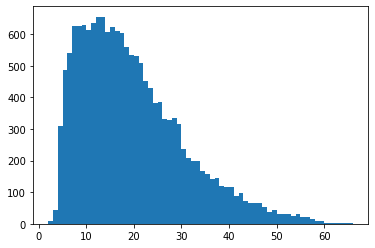

In [20]:
# calculating the lenghts of the tweets and displaying the distribution of lengths
lenghts = [len(t.split(' '))for t in tweets]
plt.hist(lenghts, bins = len(set(lenghts)))
plt.show()

#### most of the tweets are about 10 to 20 words long.

In [21]:
# we will truncate the tweets that have more than 50 words and pad the tweets with zeros
maxlen = 50
from tensorflow.keras.preprocessing.sequence import  pad_sequences

In [22]:
# function that we'll use to get sequences for our different sets
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)   # creating the sequences
  padded = pad_sequences(sequences, truncating='post', padding='post',maxlen=maxlen) # truncating tweets with len<50, and padding the sequences.
  return padded

In [23]:
padded_train_seq = get_sequences(tokenizer,tweets)

In [24]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Preparing the Labels



In [25]:
classes = set(labels) # this returns the unique classes that we have
print(classes)

{'surprise', 'love', 'anger', 'sadness', 'fear', 'joy'}


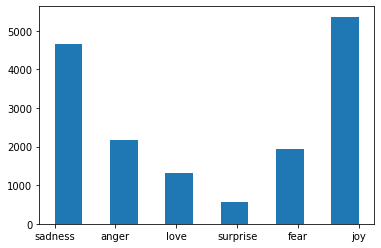

In [26]:
# showing how many tweet peer classe
plt.hist(labels, bins=11)
plt.show()

In [29]:
# creating dictionaries to be able to convert the name of the classes to their corresponding numeric values.
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items()) # to do the reverse operation

In [30]:
class_to_index

{'anger': 2, 'fear': 4, 'joy': 5, 'love': 1, 'sadness': 3, 'surprise': 0}

In [31]:
index_to_class

{0: 'surprise', 1: 'love', 2: 'anger', 3: 'sadness', 4: 'fear', 5: 'joy'}

In [32]:
# function to convert names to id
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [34]:
train_labels = names_to_ids(labels)
print(train_labels[0])              # it should print out 3 , because the first tweet in our training set is sad

3


### Creating the Model


In [37]:
# we'll use the sequencial class from keras to create the model.
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),   
        #embedding layer, 10000 is the input dimention, output dimention                                                             
        # is 16,each word will be represented as a 16 dimentional vector.
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences= True)),  
        #first LSTM layer(20 cells), this layer is inside a bidirectional layer, this means the context in LSTM can go from both left to right 
        #and left to right. every time step we will have output, the output of this layer will be fed to another bi-LSTM layer.
  
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)), 

        tf.keras.layers.Dense(6, activation='softmax')
        #Dense lyer , 6 units for the 6 classes that we have.
])

model.compile(
    loss='sparse_categorical_crossentropy',   # we used this loss because the values are not one hot encoded
    optimizer='adam',
    metrics=['accuracy']
)

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


### Training the Model


In [40]:
#preparing validation set
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)           

In [41]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [42]:
#training the model
h = model.fit(
    padded_train_seq, train_labels, 
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 1.2606 - accuracy: 0.5022 - val_loss: 0.7447 - val_accuracy: 0.7085
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5574 - accuracy: 0.7766 - val_loss: 0.5669 - val_accuracy: 0.7880
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3468 - accuracy: 0.8811 - val_loss: 0.4740 - val_accuracy: 0.8440
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2370 - accuracy: 0.9212 - val_loss: 0.4046 - val_accuracy: 0.8680
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1691 - accuracy: 0.9443 - val_loss: 0.4223 - val_accuracy: 0.8715
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1376 - accuracy: 0.9544 - val_loss: 0.4126 - val_accuracy: 0.8760
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1130 - accuracy: 0.9630 - val_loss: 0.4108 - val_accuracy: 0.8820

#### The model achieved 0.97 accuracy on the training set and 0.88 on the validation set.

### Evaluating the Model



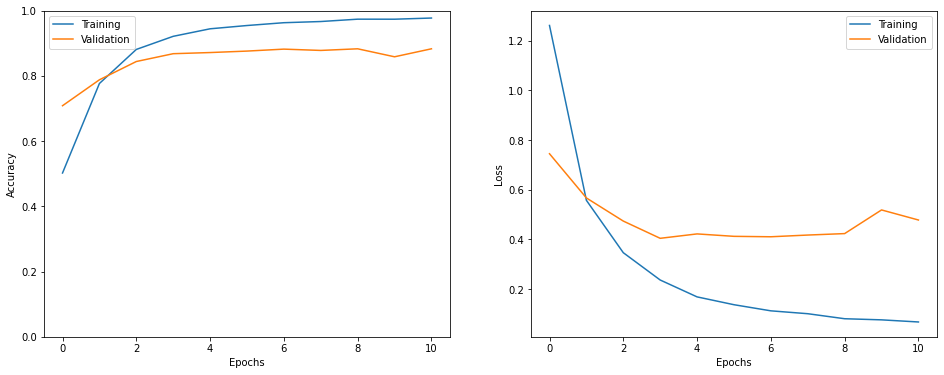

In [43]:
#Visualizing training history
show_history(h)

In [44]:
#preparing the test data
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [45]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.4746 - accuracy: 0.8700


[0.4746015965938568, 0.8700000047683716]

#### the model acheived 0.87 acurracy on the test set

In [68]:
# A look at individual predictions on the test set
i = random.randint(0, len(test_labels)-1)
print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p= model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion: ', pred_class)

Sentence:  i have faith in supreme power and i accept everything and all incidence occuring in life sometimes like today it really makes me feel very very dull and i start crying
Emotion:  sadness
Predicted Emotion:  sadness


In [51]:
# A look at all predictions on the test set
preds = model.predict_classes(test_seq)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


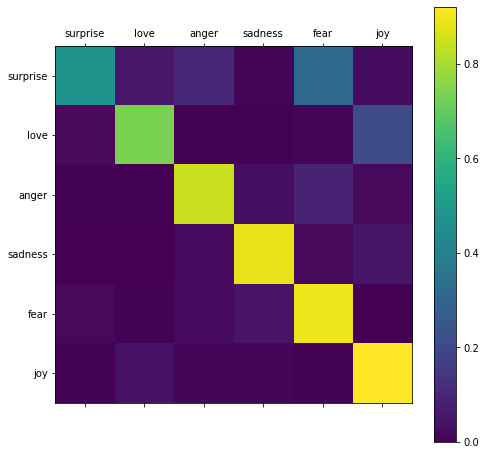

In [52]:
show_confusion_matrix(test_labels, preds, list(classes))

#### we can see some confusion between surprise/fear and joy/love. balancing the classes might be a good solution to fix these confusions.